<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/exploring_classification_hardness.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/exploring_classification_hardness.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/exploring_classification_hardness.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/exploring_classification_hardness.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# Exploring Image Hardness

Say you have a repository of data with millions of unlabeled images in it. You managed to label a subset of data and trained an image classification model on it, but it's not performing as well as you hope. **How do you decide 
which new samples to annotate and add to your training set?**

You could just randomly select new samples to annotate, but there is a better way. Hard sample mining is a tried and true method to distill a large amount of raw unlabeled data into smaller high quality labeled datasets.

*A hard sample is one that is difficult for your machine learning (ML) model to correctly predict the label of.* 

In an image classification dataset, a hard sample could be anything from a cat that looks like a dog to a blurry resolution image. If you expect your model to perform well on these hard samples, then you may need to "mine" more examples of these hard samples to add to your training dataset. Exposing your model to more hard samples during training will allow it to perform better on those types of samples later on.


Hard samples are useful for more than just training data, they are also necessary to include in your test set. If your test data is composed primarily of easy samples, then your [performance will soon reach an upper bound causing progress to stagnate](https://www.sciencedirect.com/science/article/abs/pii/S0925231219316984). Adding hard samples to a test set will give you a better idea of how models perform in harder edge cases and can provide more insight into which models are more reliable.

## Overview:

In this walkthrough, we explore how [FiftyOne’s image hardness tool](https://voxel51.com/docs/fiftyone/user_guide/brain.html) can be used to analyze and improve datasets.

We’ll cover the following concepts:

* Loading a dataset from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html)

* Applying [FiftyOne’s sample hardness algorithm](https://voxel51.com/docs/fiftyone/user_guide/brain.html) to your dataset

* Launching the [FiftyOne App and visualizing/exploring your data](https://voxel51.com/docs/fiftyone/user_guide/app.html)

* Identifying the hardest samples in your dataset

In [ ]:
!pip install fiftyone

In [ ]:
import fiftyone as fo

If the above import fails, run the following two commands. There is [currently an issue](https://github.com/voxel51/fiftyone/issues/1494) with OpenCV in Colab environments.

In [ ]:
# If the FiftyOne import failed, restart the runtime by running this cell
exit()

In [ ]:
# If the FiftyOne import failed
!pip install opencv-python-headless==4.5.4.60

import fiftyone as fo

In [ ]:
!pip install torch torchvision

## Load your data

For this example, we will be using the test split of the image classification dataset, [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset contains 10,000 test images labeled across 10 different classes. This is one of the dozens of datasets in the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html), so we can easily load it up.

In [1]:
import fiftyone as fo

In [2]:
import fiftyone.zoo as foz

In [3]:
dataset = foz.load_zoo_dataset("cifar10", split="test")

Split 'test' already downloaded
Loading 'cifar10' split 'test'
 100% |████████████████████████████████████████████████████████████| 10000/10000 [9.2s elapsed, 0s remaining, 1.1K samples/s]       
Dataset 'cifar10-test' created


**Note**: You can also [load your own dataset into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html). It supports labels for many computer vision tasks including [classification, detection, segmentation, keypoints, and more](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#labels).

## Add logits
In order to calculate hardness on images in FiftyOne, you first need to use a model to compute logits for those images. You can use any model you want, but ideally, it would be one trained similar data and on the same task you will be using these new images for.

In this example, we will be using code from the [PyTorch CIFAR-10 repository](https://github.com/huyvnphan/PyTorch_CIFAR10/tree/v2.1), namely the pretrained ResNet50 classifier.


In [ ]:
# Download the software
!git clone --depth 1 --branch v2.1 https://github.com/huyvnphan/PyTorch_CIFAR10.git

# Download the pretrained model (90MB)
!eta gdrive download --public \
    1dGfpeFK_QG0kV-U6QDHMX2EOGXPqaNzu \
    PyTorch_CIFAR10/cifar10_models/state_dicts/resnet50.pt


You can easily add a classification field with [logits to your samples in a FiftyOne dataset.](https://voxel51.com/docs/fiftyone/recipes/model_inference.html?highlight=logits)

In [4]:
import sys

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader

import fiftyone.utils.torch as fout

sys.path.insert(1, "PyTorch_CIFAR10")
from cifar10_models import resnet50


# Set up a data loader in accordance to PyTorch CIFAR10
def make_cifar10_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)


# Run inference on the model to generate predictions and logits
def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences, logits

In [5]:
#
# Load a pretrained model
#
# Model performance numbers are available at:
#   https://github.com/huyvnphan/PyTorch_CIFAR10
#

model = resnet50(pretrained=True)
model_name = "resnet50"

view = dataset

**Note**: If you want this notebook to run faster, select a subset of samples from the dataset

In [6]:
# Uncomment the lines below to select a random subset of 1000 samples

# num_samples = 10000
# view = dataset.take(num_samples, seed=51)

In [7]:
batch_size = 20

# Get the list of classes from the dataset information
classes = dataset.info["classes"]

image_paths, sample_ids = zip(
    *[(s.filepath, s.id) for s in view.select_fields(["filepath", "id"])]
)

# Create a PyTorch data loader
data_loader = make_cifar10_data_loader(image_paths, sample_ids, batch_size)

#
# Perform prediction and store results in dataset
#

for imgs, sample_ids in data_loader:
    predictions, confidences, logits_ = predict(model, imgs)

    # Add predictions to your FiftyOne dataset
    for sample_id, prediction, confidence, logits in zip(sample_ids, predictions, confidences, logits_):
        sample = dataset[sample_id]
        sample.tags.append("processed")
        sample[model_name] = fo.Classification(
            label=classes[prediction], logits=logits, confidence=confidence
        )
        sample.save()

In [8]:
processed_view = dataset.match_tags(["processed"])

In [9]:
processed_view

Dataset:        cifar10-test
Media type:     image
Num samples:    10000
Tags:           ['processed', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    resnet50:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. MatchTags(tag=['processed'])

We can use the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) to take a look at this dataset.


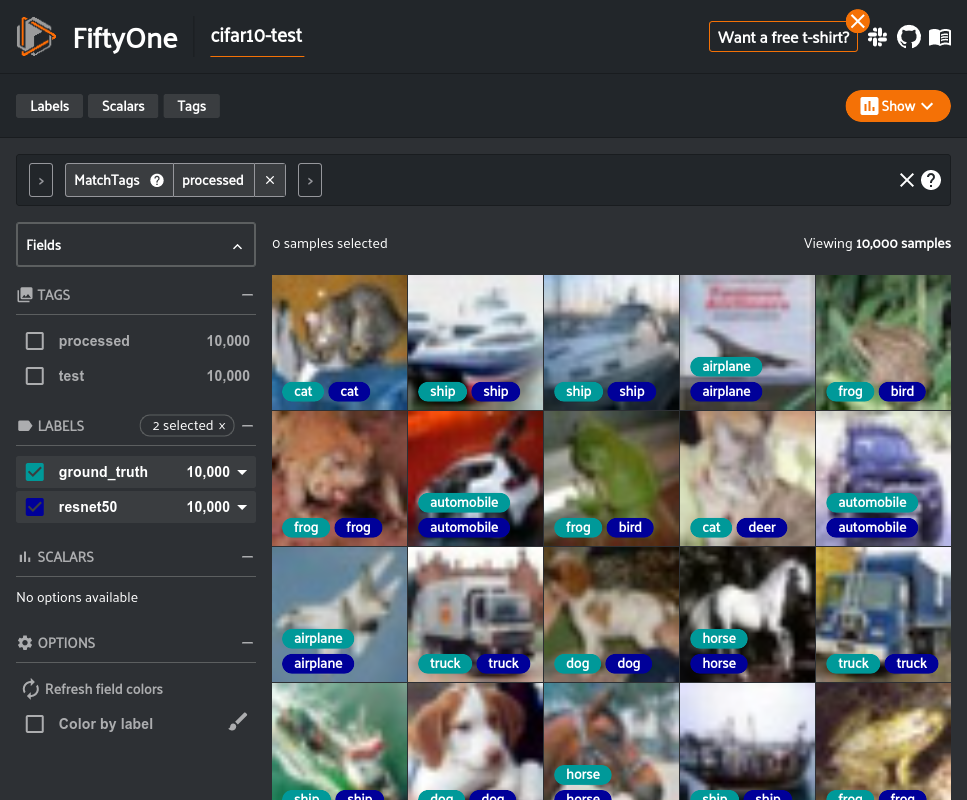

In [10]:
session = fo.launch_app(view=processed_view)

## Compute hardness

[The FiftyOne Brain](https://voxel51.com/docs/fiftyone/user_guide/brain.html) contains various useful methods that can provide insights into your data. You can compute the uniqueness of your data, the hardest samples, as well as annotation mistakes. These are all different ways to generate scalar metrics on your dataset that will let you better understand the quality of existing data as well as select help high-quality new samples of data.

Once you have loaded your dataset and added logits to your samples, you calculate hardness in one line of code. The hardness algorithm is closed-source, but the basic idea is to leverage the relative uncertainty of the model's predictions to assign a scalar hardness value to each sample.

In [11]:
import fiftyone.brain as fob

In [12]:
fob.compute_hardness(processed_view, label_field=model_name)

Computing hardness...
 100% |████████████████████████████████████████████████████████████| 10000/10000 [24.1s elapsed, 0s remaining, 409.4 samples/s]      
Hardness computation complete


## Explore and identify the hardest samples

You can visualize your dataset and explore the samples with the highest and lowest hardness scores with the FiftyOne App.


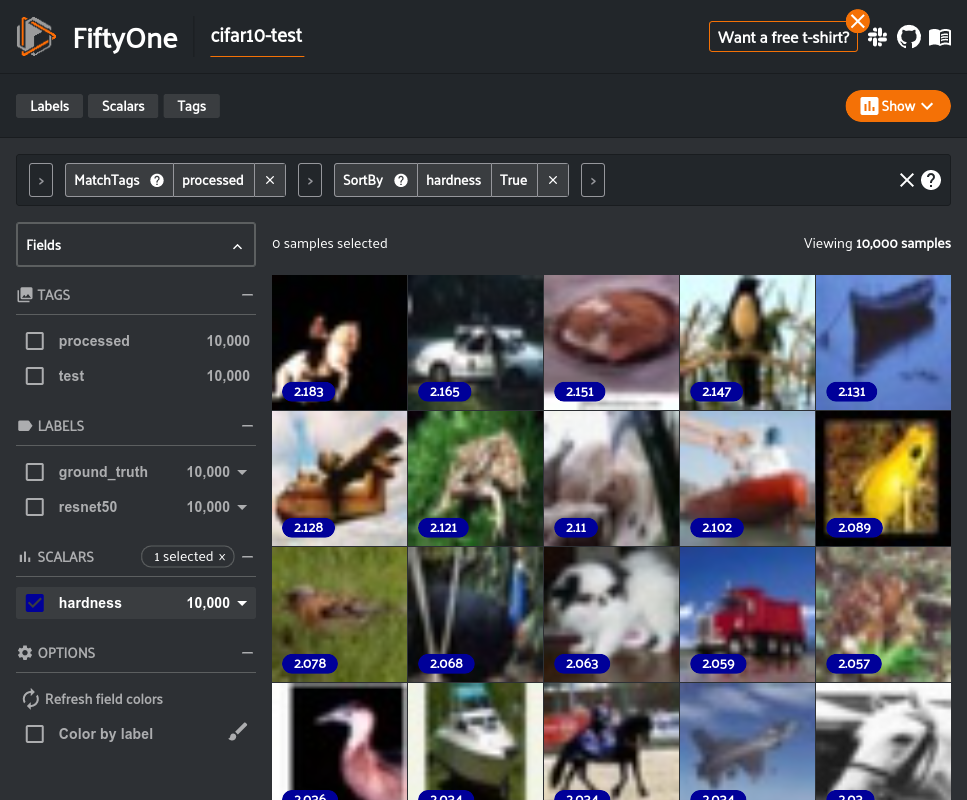

In [13]:
session.view = processed_view.sort_by("hardness", reverse=True)

While this example is using small images from CIFAR-10, FiftyOne also works with high-resolution images and videos.

We can write some queries to dig a bit deeper into these hardness calculations and how they relate to other aspects of the data. For example, we can see the distribution of hardness on correct and incorrect predictions of the model separately.

In [14]:
from fiftyone import ViewField as F

In [15]:
# Correct Preds
correct_view = processed_view.match(F("ground_truth.label") == F(model_name+".label"))

# Incorrect Preds
incorrect_view = processed_view.match(F("ground_truth.label") != F(model_name+".label"))

print(correct_view)
print(incorrect_view)

Dataset:        cifar10-test
Media type:     image
Num samples:    8183
Tags:           ['processed', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    resnet50:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    hardness:     fiftyone.core.fields.FloatField
View stages:
    1. MatchTags(tag=['processed'])
    2. Match(filter={'$expr': {'$eq': [...]}})
Dataset:        cifar10-test
Media type:     image
Num samples:    1817
Tags:           ['processed', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.Embedde

In [16]:
print("Incorrect predictions avg hardness: %f" % (incorrect_view.sum("hardness")/incorrect_view.count()))
print("Correct predictions avg hardness: %f" % (correct_view.sum("hardness")/correct_view.count()))
print("Total avg hardness: %f" % (processed_view.sum("hardness")/processed_view.count()))

Incorrect predictions avg hardness: 0.898047
Correct predictions avg hardness: 0.518320
Total avg hardness: 0.587316


In [17]:
incorrect_view.clone_sample_field("hardness", "hardness_incorrect")
correct_view.clone_sample_field("hardness", "hardness_correct")

In [18]:
for sample in processed_view:
    if sample.id in correct_view:
        sample["prediction"] = fo.Classification(label="correct")
    else:
        sample["prediction"] = fo.Classification(label="incorrect")
    sample.save()


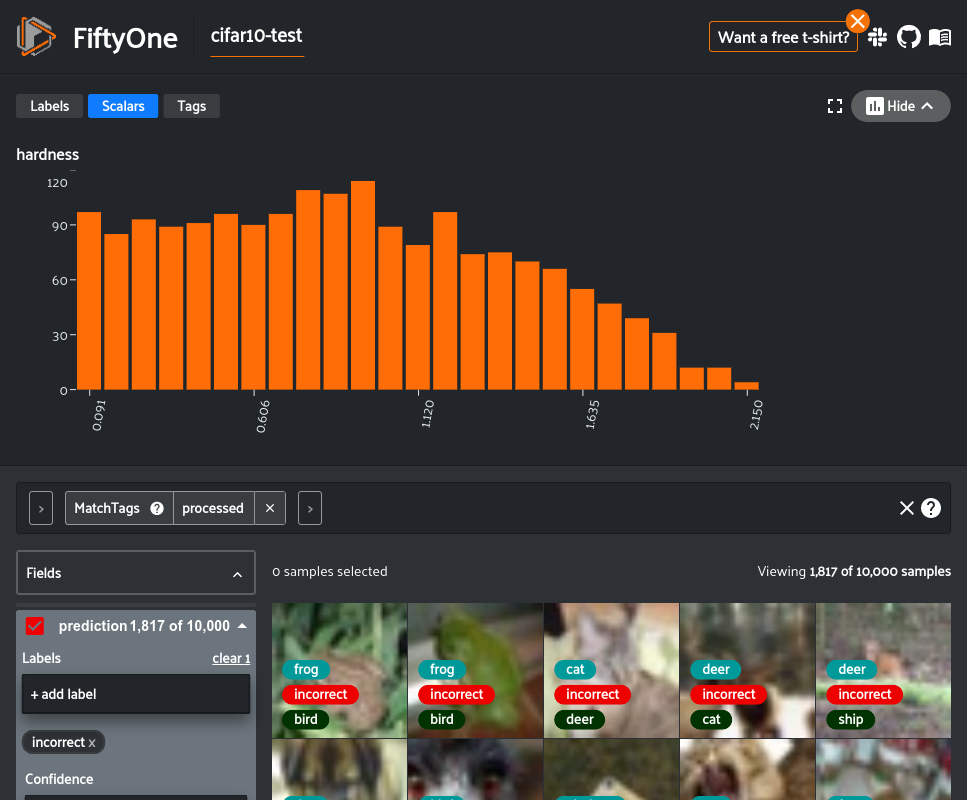

In [19]:
session.view = processed_view

As you might expect, the figure above shows that the distribution of hardness for correct predictions skews towards lower hardness values while incorrect predictions are spread more evenly at high hardness values. This indicates that samples that the model predicts incorrectly tend to be harder samples. Thus, adding harder samples to the training set should improve model performance.

We can also see how the hardness of samples is distributed across different classes.

In [20]:
cls_hardness = []

for label in processed_view.distinct("ground_truth.label"):
    label_view = processed_view.match(F("ground_truth.label")==label)
    avg_hardness = label_view.sum("hardness")/label_view.count()
    
    num_correct = correct_view.match(F("ground_truth.label")==label).count()
    accuracy = num_correct/label_view.count()
    
    cls_hardness.append([avg_hardness, label, accuracy])

print("Average classwise hardness\n")
for avg_hardness, label, _ in sorted(cls_hardness, reverse=True):
    print("%s: %f" % (label, avg_hardness))

Average classwise hardness

cat: 0.694020
dog: 0.624073
deer: 0.591152
bird: 0.584566
truck: 0.581653
frog: 0.581470
airplane: 0.576446
horse: 0.565170
ship: 0.542408
automobile: 0.532203


It seems that cat and dog tend to be the hardest classes so it would be worthwhile adding more examples of these before other classes.

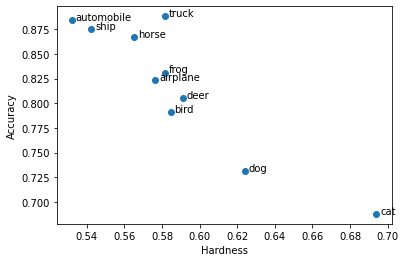

In [21]:
import matplotlib.pyplot as plt

avg_hardness = [i[0] for i in cls_hardness]
labels = [i[1] for i in cls_hardness]
acc = [i[2] for i in cls_hardness]

plt.scatter(avg_hardness, acc)
plt.xlabel("Hardness")
plt.ylabel("Accuracy")
for i, label in enumerate(labels):
    plt.annotate(label, (avg_hardness[i]+.002, acc[i]))
plt.show()

We can see that there is a fairly strong anti-correlation between the average hardness of the samples in a class and the accuracy of the model on that class.

Let's take a look at the incorrectly predicted samples of the hardest class, "cat".


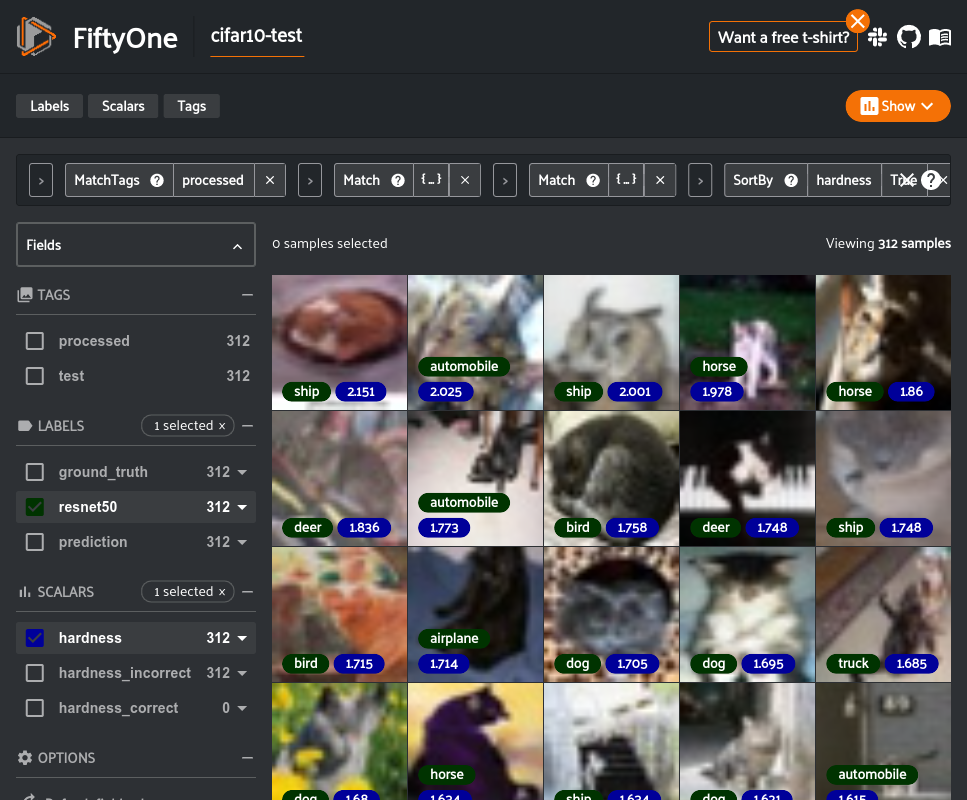

In [22]:
session.view = incorrect_view.match(F("ground_truth.label")=="cat").sort_by("hardness", reverse=True)

Now let's take a look at the correctly predicted images of cats with the lowest hardness.


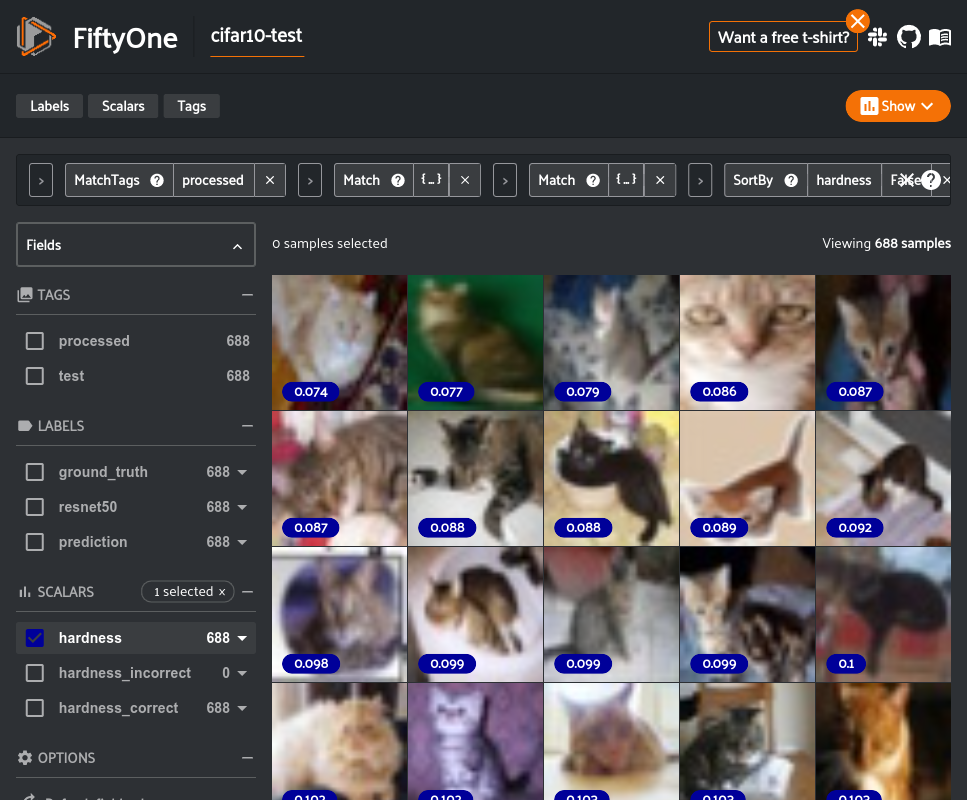

In [23]:
session.view = correct_view.match(F("ground_truth.label")=="cat").sort_by("hardness")

Comparing the hardest incorrectly predicted cat images with the easiest correctly predicted cat images, we can see that the model has a much easier time classifying images of cats faces looking directly at the camera. The images of cats that the model struggles the most with are ones of cats in poor lighting, complex backgrounds, and poses where they are not sitting and facing the camera. Now we have an idea of the types of cat images to look for to add to this dataset.

## What's next?

This example was done on a previously annotated set of data in order to show how hardness relates to other aspects of a dataset. In a real-world application, you would now apply this method to new unlabeled data.

Once you've identified the hardest samples you have available, it's time to update your dataset. You can select the X samples with the highest hardness value to send off to get annotated and added to your train or test set. Alternatively, you could select samples proportionally to the per-class hardness calculated above.

Retraining your model on this new data should now allow it to perform better on harder edge cases. Additionally, adding these samples to your test set will let you be more confident in the ability of your model to perform well on new unseen data if it performs well on your test set.

Now it's time to keep improving your dataset by [fixing annotation mistakes](https://voxel51.com/docs/fiftyone/recipes/detection_mistakenness.html) and [adding more unqiue samples](https://voxel51.com/docs/fiftyone/tutorials/uniqueness.html).